In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
raw = pd.read_csv('datasets/viz_eda.csv')

In [3]:
raw.head()

,date,series_id,value
0,2000-01-03,AAA10Y,-0.925802
1,2000-01-04,AAA10Y,-0.856570
2,2000-01-05,AAA10Y,-0.948880
3,2000-01-06,AAA10Y,-0.971957
4,2000-01-07,AAA10Y,-0.925802


In [4]:
df = raw.pivot(index = "date", columns = "series_id", values = "value")
df = df.fillna(method='ffill')

## Technical Indecator

In [5]:
def get_technical(sp500):
    tech = sp500.copy()
    tech['ma7'] = tech["SP500"].rolling(7).mean()
    tech['ma21'] = tech["SP500"].rolling(21).mean()
    tech['26ema'] = tech["SP500"].ewm(span=26).mean()
    tech['12ema'] = tech["SP500"].ewm(span=12).mean()
    tech['MACD'] = (tech['12ema']-tech['26ema'])
    tech['20sd'] = tech["SP500"].rolling(20).std()
    tech['upper_band'] = tech['ma21'] + (tech['20sd']*2)
    tech['lower_band'] = tech['ma21'] - (tech['20sd']*2)
    tech['ema'] = tech["SP500"].ewm(com=0.5).mean()
    tech['momentum'] = tech["SP500"].diff()
    tech = tech.drop(columns = "SP500").shift(periods=1)
    tech["value"] = sp500["SP500"]
    return tech[["ma7","ma21","26ema","12ema","MACD","ema","momentum"]]

In [6]:
train = pd.read_csv("datasets/observations_train.csv")
train = train[train["series_id"] == "SP500"]

In [7]:
test = pd.read_csv("datasets/observations_test.csv")
test = test[test["series_id"] == "SP500"]

In [8]:
merged = pd.concat([train,test])
merged = merged.pivot(index = "date", columns = "series_id", values = "value").dropna()

In [9]:
merged.index = merged.index.map(lambda x:x[:10])

In [10]:
merged.tail()

series_id,SP500
date,
2021-02-05,3886.83
2021-02-08,3915.59
2021-02-09,3911.23
2021-02-10,3909.88
2021-02-11,3916.38


In [11]:
tech = get_technical(merged)

In [12]:
tech.to_csv("datasets/technical.csv")

<AxesSubplot:xlabel='date'>

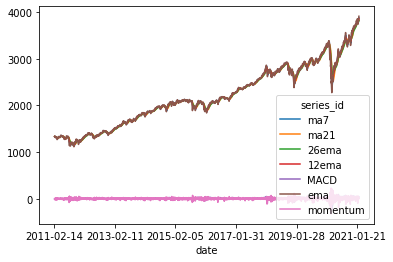

In [13]:
tech.plot()

## Fourier transforms 

In [14]:
import numpy as np
import pylab as pl
from numpy import fft

In [15]:
def fourierExtrapolation(x, n_predict, n_harm):
    n = x.size            
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

In [16]:
len(merged)

2516

In [17]:
ft = merged.copy()

In [18]:
for harm in [3,5,10,100]:
    pred = []
    for i in range(2,len(merged)):
        pred.append(fourierExtrapolation(merged.values[max(0,i - 1000) :i,0],1, harm)[-1])
    ft["ft" + str(harm)] = [np.NaN,np.NaN] + pred

<AxesSubplot:xlabel='date'>

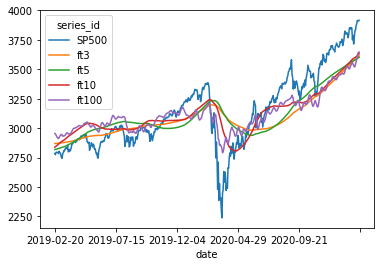

In [19]:
ft.tail(500).plot()

In [20]:
ft.to_csv("datasets/FT.csv")

In [21]:
df = df.merge(ft.drop(columns = "SP500"), how = "left", left_index=True, right_index=True)
df = df.merge(tech, how = "left", left_index=True, right_index=True)
df = df.merge(merged, how = "left", left_index=True, right_index=True)

In [22]:
df = df.rename(columns={"SP500_y": "SP500_UNNORM", "SP500_x":"SP500_NORM"})[:-1]

In [23]:
df.tail()

series_id,AAA10Y,ASEANTOT,BAA10Y,BUSAPPWNSAUS,BUSAPPWNSAUSYY,CBUSAPPWNSAUS,CBUSAPPWNSAUSYY,CUUR0000SA0R,DEXCHUS,DEXUSEU,...,ft10,ft100,ma7,ma21,26ema,12ema,MACD,ema,momentum,SP500_UNNORM
date,,,,,,,,,,,,,,,,,,,,,
2021-02-05,-0.302713,-0.579975,-0.590471,0.267132,0.918991,-1.326439,0.449925,-1.372066,-0.890475,-0.016433,...,3611.431566,3590.017641,3793.495714,3807.418571,3784.386288,3810.696264,26.309976,3855.072016,41.57,3886.83
2021-02-08,-0.348868,-0.579975,-0.644321,0.267132,0.918991,-1.326439,0.449925,-1.372066,-0.890475,-0.016433,...,3616.256460,3613.712825,3812.932857,3814.022857,3791.974711,3822.409146,30.434435,3876.244005,15.09,3915.59
2021-02-09,-0.348868,-0.579975,-0.630858,0.267132,0.918991,-1.326439,0.449925,-1.372066,-0.890475,-0.016433,...,3621.723071,3635.490488,3831.248571,3819.346667,3801.131399,3836.744662,35.613263,3902.474668,28.76,3911.23
2021-02-10,-0.325791,-0.579975,-0.617396,0.267132,0.918991,-1.326439,0.449925,-1.372066,-0.890475,-0.016433,...,3626.926072,3646.157792,3859.390000,3823.468095,3809.286851,3848.203945,38.917094,3908.311556,-4.36,3909.88
2021-02-11,-0.325791,-0.579975,-0.617396,0.267132,0.918991,-1.326439,0.449925,-1.372066,-0.890475,-0.016433,...,3631.752725,3645.888210,3878.821429,3828.719048,3816.738195,3857.692569,40.954373,3909.357185,-1.35,3916.38


In [24]:
df.isna().mean()

series_id
AAA10Y            0.000000
ASEANTOT          0.163169
BAA10Y            0.000000
BUSAPPWNSAUS      0.251065
BUSAPPWNSAUSYY    0.300458
                    ...   
12ema             0.603125
MACD              0.603125
ema               0.603125
momentum          0.603282
SP500_UNNORM      0.602967
Length: 82, dtype: float64

In [25]:
df.to_csv("datasets/all_features.csv")